In [2]:
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score

In [4]:
def train_dummy_classifier(X_train, y_train, X_test, y_test):
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    testacc, testrecall, testprecision = model_evaluation(y_test, y_pred)
    return dummy_clf, testacc, testrecall, testprecision

In [6]:
def train_knn_classifier(X_train, y_train, X_test, y_test, k = 15):
    classifier = KNeighborsClassifier(n_neighbors=k)  
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    testacc, testrecall, testprecision = model_evaluation(y_test, y_pred)
    return classifier, testacc, testrecall, testprecision

In [8]:
def extract_X_Y(df) :
    X = df [["x", "y"]].values
    Y = df ["result"].values
    return X, Y

In [10]:
def run_dummy_stage(data_frame):
    features, labels = extract_X_Y(data_frame)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.40)
    dummy_model, acc, recall, precision = train_dummy_classifier(X_train, y_train, X_test, y_test)
    return {
        "model": dummy_model,
        "test_data": (X_test, y_test),
        "metrics": {"accuracy": acc, "recall": recall, "precision": precision}
    }

In [24]:
def model_evaluation(y_test, y_pred) :
    print('Trained Model Test Data Accuracy Score :',accuracy_score(y_test, y_pred)*100)
    testacc=accuracy_score(y_test, y_pred)
    testrecall=recall_score(y_test, y_pred)
    testprecision=precision_score(y_test, y_pred)
    print(' ')
    print(classification_report(y_test, y_pred))
    return testacc, testrecall, testprecision

In [26]:
def run_knn_stage(data_frame):
    features, labels = extract_X_Y(data_frame)
    X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(features, labels, test_size=0.40)
    X_train, X_eval, y_train, y_eval = train_test_split(X_train_full, y_train_full, test_size=0.40)

    knn_model, acc, recall, precision = train_knn_classifier(X_train, y_train, X_eval, y_eval)
    metrics_training = {"accuracy": acc, "recall": recall, "precision": precision}

    y_pred = knn_model.predict(X_test_final)
    acc_pred, recall_pred, precision_pred = model_evaluation(y_test_final, y_pred)
    metrics_prediction = {"accuracy": acc_pred, "recall": recall_pred, "precision": precision_pred}

    return {
        "model": knn_model,
        "metrics_training": metrics_training,
        "metrics_prediction": metrics_prediction,
        "test_data": (X_test_final, y_test_final)
    }

In [28]:
def batch_model_steps(train_file_path, retrain_file_path):
    # Initialize results dictionary
    results = {}

    # Step 1: Dummy Classifier
    dummy_results = run_dummy_stage(pd.read_csv(train_file_path))
    results["DummyClassifier"] = dummy_results["metrics"]

    # Step 2 & 3: Initial KNN Training and Prediction
    initial_knn_results = run_knn_stage(pd.read_csv(train_file_path))
    results["KNNClassifier"] = initial_knn_results["metrics_training"]
    results["KNNClassifierPrediction"] = initial_knn_results["metrics_prediction"]

    # Step 4 & 5: Retrained KNN Training and Prediction
    retrained_knn_results = run_knn_stage(pd.read_csv(retrain_file_path))
    results["KNNClassifierRetrained"] = retrained_knn_results["metrics_training"]
    results["KNNClassifierRetrainedPrediction"] = retrained_knn_results["metrics_prediction"]

    return results

In [30]:
def construct_results_dataframe(model_results):
    formatted_data = []

    for stage_name, metrics in model_results.items():
        metrics_with_stage = metrics.copy()
        metrics_with_stage["stage_name"] = stage_name
        formatted_data.append(metrics_with_stage)

    results_dataframe = pd.DataFrame(formatted_data)
    return results_dataframe

In [32]:
def plot_graph(results_df):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(results_df["stage_name"], results_df["accuracy"], marker='o', label='Accuracy', linewidth=2)
    plt.plot(results_df["stage_name"], results_df["recall"], marker='o', label='Recall', linewidth=2)
    plt.plot(results_df["stage_name"], results_df["precision"], marker='o', label='Precision', linewidth=2)
    
    # Graph formatting
    plt.title("Batch Model Performance Metrics Across Steps")
    plt.xlabel("Steps")
    plt.ylabel("Metric Value")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=30) 
    plt.tight_layout()
    plt.show()

In [34]:
def plot_performance_metrics(results_dataframe):
    # Initialize the figure
    plt.figure(figsize=(10, 6))

    # Plot each performance metric
    plt.plot(results_dataframe["stage_name"], results_dataframe["accuracy"], marker='o', label='Accuracy', linewidth=2)
    plt.plot(results_dataframe["stage_name"], results_dataframe["recall"], marker='o', label='Recall', linewidth=2)
    plt.plot(results_dataframe["stage_name"], results_dataframe["precision"], marker='o', label='Precision', linewidth=2)

    # Customize the plot
    plt.title("Batch Model Performance Metrics Across Steps", fontsize=14)
    plt.xlabel("Modeling Steps", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=30)
    plt.tight_layout()

    # Display the plot
    plt.show()

Trained Model Test Data Accuracy Score : 49.75
 
              precision    recall  f1-score   support

       False       0.51      0.51      0.51       206
        True       0.48      0.48      0.48       194

    accuracy                           0.50       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.50      0.50      0.50       400

Trained Model Test Data Accuracy Score : 86.25
 
              precision    recall  f1-score   support

       False       0.85      0.90      0.88       130
        True       0.87      0.82      0.85       110

    accuracy                           0.86       240
   macro avg       0.86      0.86      0.86       240
weighted avg       0.86      0.86      0.86       240

Trained Model Test Data Accuracy Score : 90.5
 
              precision    recall  f1-score   support

       False       0.90      0.92      0.91       211
        True       0.91      0.88      0.90       189

    accuracy                        

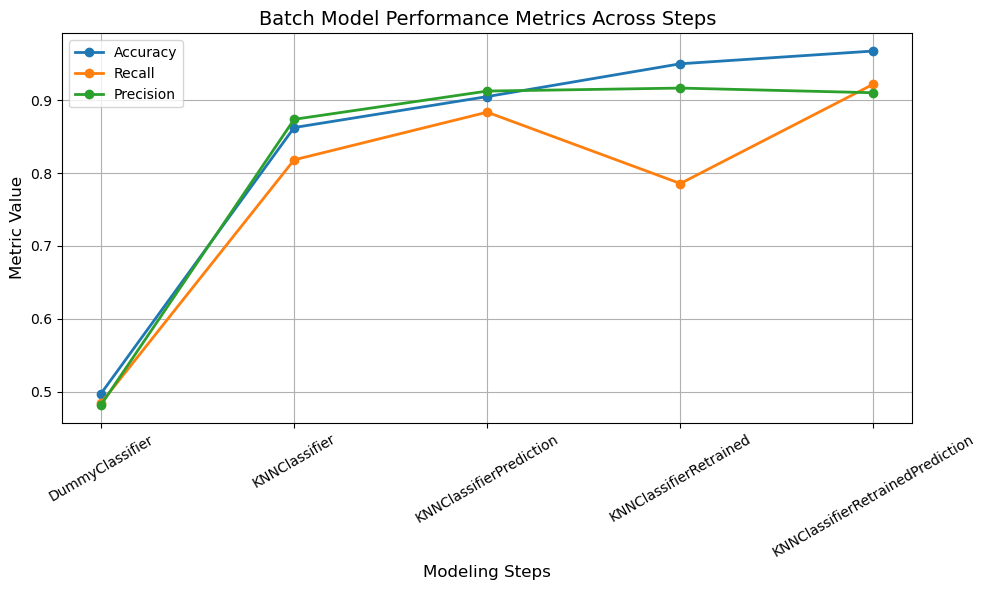

In [36]:
train_file_path = "second.csv"
retrain_file_path = "third.csv"
results = batch_model_steps(train_file_path, retrain_file_path)
results_dataframe = construct_results_dataframe(results)
plot_performance_metrics(results_dataframe)